In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time

from random import randint
from sklearn.decomposition import PCA
from tensorflow.keras import layers, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Rescaling, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

#### Run below cell to load models for examples (long training times) *PCA model needs to be trained again

In [3]:
KerasAE = tf.keras.models.load_model('KerasAE')
CAE = tf.keras.models.load_model('Conv AE')
AE = tf.keras.models.load_model('Simple AE')
OnePoolAE = tf.keras.models.load_model('OnePool')

## Import and scale the data

In [4]:
(x_train, y_train), (x_test, _y_test) = mnist.load_data()
x_train = x_train/255
x_test = x_test/255

## Split the data depending on class label

In [6]:
samples = [[] for _ in range(10)]
for i in range(len(y_train)-1):
    for j in range(10):
        if y_train[i]==j:
            samples[j].append(x_train[i])  

## Create output data (x_increment) 

In [7]:
def getRand(array): 
    return array[randint(0,len(array)-1)]

In [8]:
x_increment = [[] for _ in range(len(x_train))]
for i in range(len(x_increment)):
    for j in range(9):
        if y_train[i] == j:
            x_increment[i] = getRand(samples[j+1])
    if y_train[i] == 9:
        x_increment[i] = getRand(samples[0])
x_increment = np.asarray(x_increment)

#### x_increment examples

Text(0.5, 1.0, 'Increment')

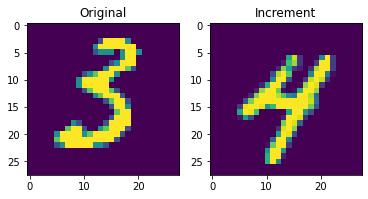

In [7]:
b = [12464,28645,23724,12,4938,2387,1298,298]
a = b[2]
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(x_train[a])
ax1.set_title('Original')
ax2.imshow(x_increment[a])
ax2.set_title('Increment')

## PCA 

In [9]:
pca = PCA(n_components = 32)
X_PCA = Flatten()(x_train)
pca.fit(X_PCA)

PCA(n_components=32)

In [11]:
PCAMatcher = Sequential()
PCAMatcher.add(Dense(units = 32, activation = 'relu', input_shape = (32,)))
PCAMatcher.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [12]:
PCAMatcher.fit(pca.transform(X_PCA), pca.transform(Flatten()(x_increment)), epochs = 60, batch_size = 64)

Epoch 1/60
938/938 [==============================] - 2s 1ms/step - loss: 1.8784
Epoch 2/60
938/938 [==============================] - 1s 1ms/step - loss: 0.8596
Epoch 3/60
938/938 [==============================] - 1s 1ms/step - loss: 0.3713
Epoch 4/60
938/938 [==============================] - 1s 1ms/step - loss: 0.0168
Epoch 5/60
938/938 [==============================] - 1s 1ms/step - loss: -0.2343
Epoch 6/60
938/938 [==============================] - 1s 1ms/step - loss: -0.4218
Epoch 7/60
938/938 [==============================] - 1s 1ms/step - loss: -0.5741
Epoch 8/60
938/938 [==============================] - 1s 1ms/step - loss: -0.7054
Epoch 9/60
938/938 [==============================] - 1s 1ms/step - loss: -0.8163
Epoch 10/60
938/938 [==============================] - 1s 1ms/step - loss: -0.9339
Epoch 11/60
938/938 [==============================] - 1s 1ms/step - loss: -1.0241
Epoch 12/60
938/938 [==============================] - 1s 1ms/step - loss: -1.0686
Epoch 13/60
938/9

## MLP Autoencoder

In [ ]:
Encoder = Sequential() 
Encoder.add(Input(shape = (28,28)))
Encoder.add(Flatten())
Encoder.add(Dense(units = 512, activation='relu'))
Encoder.add(Dropout(0.5))
Encoder.add(Dense(units = 256, activation='relu'))
Encoder.add(Dropout(0.5))
Encoder.add(Dense(units = 128, activation='relu'))
Encoder.add(Dropout(0.5))
Encoder.add(Dense(units = 64, activation='relu'))
Encoder.add(Dropout(0.5))
Encoder.add(Dense(units = 32, activation = 'sigmoid'))

In [ ]:
Decoder = Sequential()
Decoder.add(Dense(units = 64, activation='relu', input_shape = (32,)))
Decoder.add(Dropout(0.5))
Decoder.add(Dense(units = 128, activation='relu'))
Decoder.add(Dropout(0.5))
Decoder.add(Dense(units = 256, activation='relu'))
Decoder.add(Dropout(0.5))
Decoder.add(Dense(units = 512, activation='relu'))
Decoder.add(Dropout(0.5))
Decoder.add(Dense(units = 784, activation = 'sigmoid'))
Decoder.add(Reshape((28,28)))

In [ ]:
AE = Model(inputs = Encoder.input, outputs = Decoder(Encoder.outputs))
AE.compile("adam", loss = "binary_crossentropy")

In [ ]:
history = AE.fit(x_train, x_increment, epochs = 60, batch_size = 64)

In [ ]:
b = [1464,2645,23724,12,4938,2387,1298,298]
a = b[7]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(x_test[a])
ax2.imshow(x_increment[a])
ax3.imshow(AE(np.expand_dims(x_test[a], axis=0))[0])



## Convolutional Autoencoders

### Only Conv layers - Keras

In [ ]:
KerasEncoder = Sequential() 
KerasEncoder.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same', input_shape=[28,28,1]))
KerasEncoder.add(MaxPooling2D(pool_size=(2,2), padding = 'same'))
KerasEncoder.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same'))
KerasEncoder.add(MaxPooling2D(pool_size=(2,2), padding = 'same'))
KerasEncoder.add(Conv2D(filters = 8, kernel_size = 2, activation = 'relu', padding = 'same')) 
KerasEncoder.add(MaxPooling2D(pool_size=(2,2), padding = 'same')) #4x4x8

In [ ]:
KerasDecoder = Sequential() 
KerasDecoder.add(Conv2D(filters = 8, kernel_size = 3, activation = 'relu', padding = 'same', input_shape=[4,4,8]))
KerasDecoder.add(UpSampling2D(size=(2,2)))
KerasDecoder.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu', padding = 'same'))
KerasDecoder.add(UpSampling2D(size=(2,2)))
KerasDecoder.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
KerasDecoder.add(UpSampling2D(size=(2,2)))
KerasDecoder.add(Conv2D(filters = 1, kernel_size = 3, activation = 'sigmoid', padding = 'same'))

In [ ]:
KerasAE = Model(inputs = KerasEncoder.input, outputs = KerasDecoder(KerasEncoder.outputs))
KerasAE.compile("adam", loss = "binary_crossentropy")

In [ ]:
KerasHistory = KerasAE.fit(x_train, x_increment, epochs = 40, batch_size = 64)

### Conv Autoencoder with MLP

In [ ]:
CEncoder = Sequential() 
CEncoder.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape=[28,28,1]))
CEncoder.add(MaxPooling2D(pool_size=(2,2)))
CEncoder.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
CEncoder.add(MaxPooling2D(pool_size=(2,2)))
CEncoder.add(Conv2D(filters = 8, kernel_size = 2, activation = 'relu')) 
CEncoder.add(Flatten()) 
CEncoder.add(Dense(units = 64, activation='relu'))
CEncoder.add(Dropout(0.5))
CEncoder.add(Dense(units = 32, activation = 'relu'))

In [ ]:
CDecoder = Sequential()
CDecoder.add(Dense(units = 64, activation='relu', input_shape = (32,)))
CDecoder.add(Dropout(0.5))
CDecoder.add(Dense(units = 128, activation='relu'))
CDecoder.add(Reshape((4,4,8)))
CDecoder.add(Conv2DTranspose(filters=8, kernel_size=2, activation='relu'))
CDecoder.add(UpSampling2D(size=(2,2)))
CDecoder.add(Conv2DTranspose(filters=16, kernel_size=3, activation='relu'))
CDecoder.add(UpSampling2D(size=(2,2)))
CDecoder.add(Conv2DTranspose(filters=32, kernel_size=3, activation='relu'))
CDecoder.add(Conv2DTranspose(filters = 1, kernel_size = 3, activation = 'sigmoid'))

In [ ]:
CAE = Model(inputs = CEncoder.input, outputs = CDecoder(CEncoder.outputs))
CAE.compile("adam", loss = "binary_crossentropy")

In [ ]:
ConvHistory = CAE.fit(x_train, x_increment, epochs = 60, batch_size = 64)

In [ ]:
b = [1464,2645,2724,12,4938,2387,1298,298]
a = b[7]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(x_test[a])
ax2.imshow(x_increment[a])
ax3.imshow(CAE(np.expand_dims(x_test[a], axis=0))[0])

## Conv Autoencoder with only 1 Pooling layer

In [ ]:
OnePoolEncoder = Sequential() 
OnePoolEncoder.add(Conv2D(filters = 16, kernel_size = 3, activation = 'relu', input_shape=[28,28,1])) #26x26x16
OnePoolEncoder.add(MaxPooling2D(pool_size=(2,2))) #13x13x16
OnePoolEncoder.add(Conv2D(filters = 8, kernel_size = 2, activation = 'relu')) #13x13x8 
OnePoolEncoder.add(Flatten()) 
OnePoolEncoder.add(Dense(units = 256, activation='relu'))
OnePoolEncoder.add(Dropout(0.5))
OnePoolEncoder.add(Dense(units = 64, activation = 'relu'))
OnePoolEncoder.add(Dropout(0.5))
OnePoolEncoder.add(Dense(units = 32, activation='relu'))

In [ ]:
OnePoolDecoder = Sequential()
OnePoolDecoder.add(Dense(units = 64, activation='relu', input_shape = (32,)))
OnePoolDecoder.add(Dropout(0.5))
OnePoolDecoder.add(Dense(units = 256, activation='relu'))
OnePoolDecoder.add(Dropout(0.5))
OnePoolDecoder.add(Dense(units = 1352, activation='relu'))
OnePoolDecoder.add(Reshape((13,13,8)))
OnePoolDecoder.add(Conv2DTranspose(filters=8, kernel_size=2, activation='relu'))
OnePoolDecoder.add(UpSampling2D(size=(2,2)))
OnePoolDecoder.add(Conv2DTranspose(filters=16, kernel_size=3, activation='relu'))
OnePoolDecoder.add(Conv2D(filters = 1, kernel_size = 3, activation = 'sigmoid'))

In [ ]:
OnePoolAE = Model(inputs = OnePoolEncoder.input, outputs = OnePoolDecoder(OnePoolEncoder.outputs))
OnePoolAE.compile("adam", loss = "binary_crossentropy")

In [ ]:
OnePoolHistory = OnePoolAE.fit(x_train, x_increment, epochs = 60, batch_size = 64)

## Examples

Text(0.5, 1.0, 'PCA')

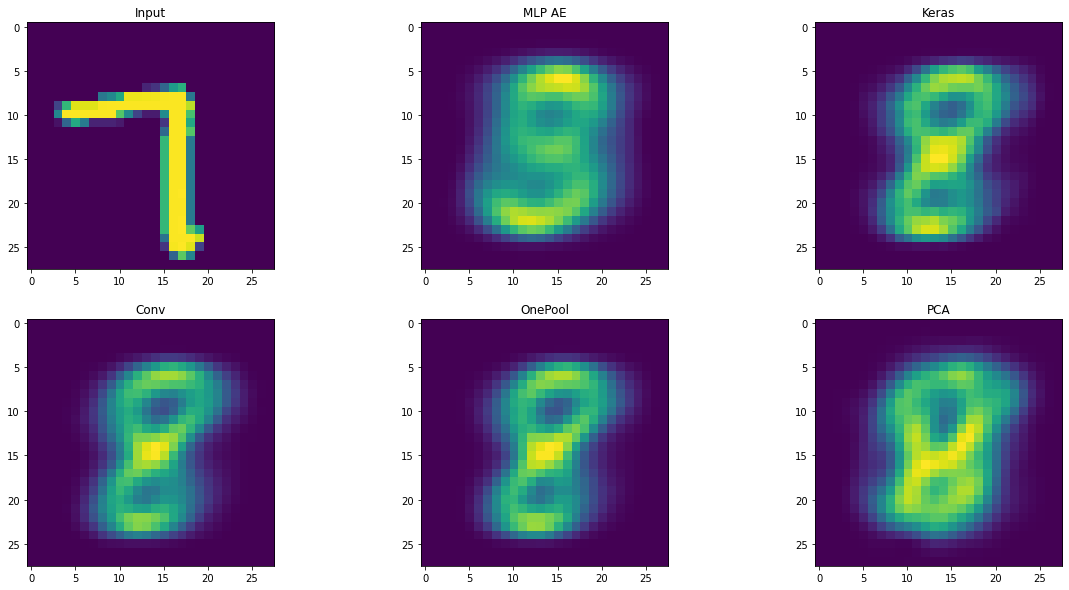

In [16]:
fig, axs = plt.subplots(nrows = 2,ncols = 3, figsize=(20, 10))
a = 4938 # use a in [0,9999] to get a random example from the test set

PCAin = Flatten()(x_test)
PCAout = Reshape((10000,28,28))((np.expand_dims(pca.inverse_transform(PCAMatcher(pca.transform(PCAin))), axis=0)))[0]

axs[0,0].imshow(x_test[a])
axs[0,0].set_title('Input')
axs[0,1].imshow(AE(np.expand_dims(x_test[a], axis=0))[0])
axs[0,1].set_title('MLP AE')
axs[0,2].imshow(KerasAE(np.expand_dims(x_test[a], axis=0))[0])
axs[0,2].set_title('Keras')
axs[1,0].imshow(CAE(np.expand_dims(x_test[a], axis=0))[0])
axs[1,0].set_title('Conv')
axs[1,1].imshow(OnePoolAE(np.expand_dims(x_test[a], axis=0))[0])
axs[1,1].set_title('OnePool')
axs[1,2].imshow(PCAout[a])
axs[1,2].set_title('PCA')